In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER,LATITUDE_FORMATTER
import os,errno
import sys
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import pandas as pd
%matplotlib inline

dir2='/thorncroftlab_rit/ahenny/rain/'
dir1='/thorncroftlab_rit/ahenny/rain/US/ghcnd_all/'
dir='/thorncroftlab_rit/ahenny/rain/DISSERTATION_SCRIPTS_RESULTS/'
#This script plots trends in season total EP day precipitation

In [ ]:
ds=xr.open_dataset(dir+'ls_extreme_rain_taiwan.nc')
p=ds['large_scale_extreme_rain_all']#total rainfall on ER days
threshold=ds['threshold_99']
dates=ds.large_scale_extreme_days
dates=pd.DatetimeIndex(dates.values)
p['large_scale_extreme_days']=dates
print(p)
print(dates)

In [ ]:
yrs_taiwan=np.arange(1979,2020,1)
print(p)
p_annual_array=xr.zeros_like(p[0:len(yrs_taiwan),:,:])
for i in range(len(yrs_taiwan)):
    year=yrs_taiwan[0]+i
    print(year)
    dates_list=[x for x in dates if x.year==year]
    dates_list=pd.DatetimeIndex(dates_list).values
    if len(dates_list)>0:
        p_year=p.sel(large_scale_extreme_days=dates_list)
        p_year_sum=p_year.sum(dim='large_scale_extreme_days',skipna=True)*30./47.#monthly
    else:
        p_year=xr.zeros_like(p[0,:,:])
        p_year_sum=p_year
    p_annual_array[i,:,:]=p_year_sum.values
print(p_annual_array)

In [4]:
#@author: Michael Schramm on GitHub
#This function is derived from code originally posted by Sat Kumar Tomer
#(satkumartomer@gmail.com)
#See also: http://vsp.pnnl.gov/help/Vsample/Design_Trend_Mann_Kendall.htm

from scipy.stats import norm
import scipy.stats as st
def mk_test(x, alpha=0.05):
    n = len(x)

    # calculate S
    s = 0
    for k in range(n-1):
        for j in range(k+1, n):
            s += np.sign(x[j] - x[k])

    # calculate the unique data
    unique_x, tp = np.unique(x, return_counts=True)
    g = len(unique_x)

    # calculate the var(s)
    if n == g:  # there is no tie
        var_s = (n*(n-1)*(2*n+5))/18
    else:  # there are some ties in data
        var_s = (n*(n-1)*(2*n+5) - np.sum(tp*(tp-1)*(2*tp+5)))/18

    if s > 0:
        z = (s - 1)/np.sqrt(var_s)
    elif s < 0:
        z = (s + 1)/np.sqrt(var_s)
    else: # s == 0:
        z = 0

    # calculate the p_value
    p = 2*(1-norm.cdf(abs(z)))  # two tail test
    h = abs(z) > norm.ppf(1-alpha/2)

    if (z < 0) and h:
        trend = 'decreasing'
    elif (z > 0) and h:
        trend = 'increasing'
    else:
        trend = 'no trend'

    return trend, h, p, z

In [ ]:
trends=xr.zeros_like(p[0,:,:])
sigs=xr.zeros_like(p[0,:,:])
sigsa=xr.zeros_like(p[0,:,:])
for i in range(p_annual_array.lat.size):
    print(i)
    for j in range(p_annual_array.lon.size):
        time_series=p_annual_array[:,i,j].values.tolist()
        if sum(time_series)>0:
            trend=mk_test(time_series,alpha=0.05)[0]
            trenda=mk_test(time_series,alpha=0.1)[0]
            #slope=st.theilslopes(time_series,alpha=0.95)[0]
            slope=st.linregress(yrs_taiwan,time_series)[0]
            if trend=='increasing':
                sig=1
            elif trend=='decreasing':
                sig=-1
            else:
                sig=0
                
            if trenda=='increasing':
                siga=1
            elif trenda=='decreasing':
                siga=-1
            else:
                siga=0
            trends[i,j]=slope
            sigs[i,j]=sig
            sigsa[i,j]=siga
        else:
            trends[i,j]=np.nan
            sigs[i,j]=np.nan
            sigsa[i,j]=np.nan

In [6]:
annual_mean=p_annual_array.mean(dim='large_scale_extreme_days',skipna=True)
trends_percent=trends/annual_mean*100.

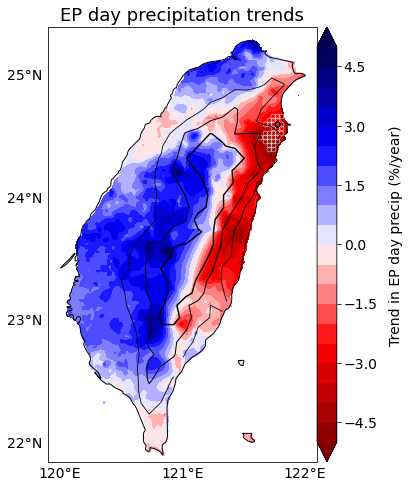

In [11]:
fig = plt.figure(figsize=(9,8))
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
cax=ax.contourf(trends.lon,trends.lat,trends_percent,levels=np.arange(-5,5.5,0.5),extend='both',cmap=plt.cm.seismic_r)
cbar=plt.colorbar(cax,pad=0,fraction=0.042)
    
Y=4.

for i in range(int(trends.lat.size/Y)):
    for j in range(int(trends.lon.size/Y)):
        if sigsa[int(i*Y),int(j*Y)].values in [-1,1]:
            ax.plot(trends.lon[int(j*Y)],trends.lat[int(i*Y)],marker='o',color='w',markersize=5,mew=0.5,markerfacecolor='None')
            
            
for i in range(int(trends.lat.size/Y)):
    for j in range(int(trends.lon.size/Y)):
        if sigs[int(i*Y),int(j*Y)].values in [-1,1]:
            ax.plot(trends.lon[int(j*Y)],trends.lat[int(i*Y)],marker='o',color='k',markersize=5,mew=1.5,markerfacecolor='None')
            
dy1=xr.open_dataset(dir2+'etopo1-2.nc')
elevation=dy1['Band1']
X=6
elevation_deres=xr.zeros_like(elevation[0::X,0::X])
elevation_deres['lat']=[x+float(X)/2./111. for x in elevation_deres.lat.values]
elevation_deres['lon']=[x+float(X)/2./102. for x in elevation_deres.lon.values]
for j in range(int(elevation.lat.size/X)):
    for k in range(int(elevation.lon.size/X)):
        elevation_block=elevation[X*j:X*(j+1),X*k:X*(k+1)]
        elevation_mean=elevation_block.mean(dim=('lat','lon')).values
        elevation_deres[j,k]=elevation_mean
elevation_deres=elevation_deres.where(elevation_deres>-200)
ax.contour(elevation_deres.lon,elevation_deres.lat,elevation_deres,levels=[400,1200,2000,2800,3600,4400],colors='k',linewidths=[0.8,1.0,1.4,1.6,1.8,2.0],zorder=20,alpha=1.0)
ax.coastlines(resolution='10m')
g1=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1.5,color='gray',alpha=0.0,linestyle='--')
cbar.ax.tick_params(labelsize=14) 
g1.xlabel_style={'size':14,'color':'k'}
g1.ylabel_style={'size':14,'color':'k'}
g1.xformatter=LONGITUDE_FORMATTER
g1.yformatter=LATITUDE_FORMATTER
g1.xlocator = mticker.FixedLocator([119,120,121,122,123])
g1.ylocator = mticker.FixedLocator([21,22,23,24,25,26])

g1.xlabels_top=False
g1.ylabels_right=False
ax.set_xlim(119.9,122.1)
ax.set_ylim(21.85,25.4)
ax.set_title('EP day precipitation trends',fontsize=18)

ax.text(122.8,23.7,'Trend in EP day precip (%/year)',ha='right',va='center',rotation=90,fontsize=14)
plt.show()

In [12]:
fig.savefig(dir+'taiwan_annual_extreme_trends_5p'+'.png')